In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import openmc

import os
import numpy as np

In [28]:
#Initial starting source, uniform in fuel only
bounds = [-0.4, -0.4, -0.4, 0.4, 0.4, 0.4]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)

#constants for part switches
PART_A= 0b001
PART_B= 0b010
PART_C= 0b100

In [29]:
batches=100
settings = openmc.Settings()
settings.source = openmc.source.Source(space=uniform_dist)
settings.batches = batches
settings.inactive = 25  # keep this at a min of 25, this is the number of power iterations performed, more is always better
settings.particles = 10000  # increase this number to make your results more accurate
#settings.particles=100
settings.temperature = {'tolerance':10000,'multipole':True}
#settings.temperature = {'method':'interpolation','multipole':True}
settings.export_to_xml()

def buildRange(lower, upper, steps):
    out=[]
    stepSize=(upper-lower)/(steps)
    buffer=lower
    while buffer<=upper:
        out.append(buffer)
        buffer+=stepSize
    return out

In [30]:

def getU(T,DyFrac,enrich):
    #got to watch out for those Uranium diggers
    #nukeLife
    uo2 = openmc.Material(1,"fuel",temperature=T)
    uo2.add_element('U', 1.0, enrichment=enrich)
    uo2.add_element('Dy',2.0*DyFrac)
    uo2.add_element('O', 2.0+3.0*DyFrac)
    uo2.set_density('g/cc', 10.0)
    return uo2
def getZirc():
    zirconium = openmc.Material(2, "zirconium", temperature=temp2)
    zirconium.add_element('Zr', 1.0)
    zirconium.set_density('g/cm3', 6.6)
    return zirconium

def getMod(mod, boron,T):
    if(mod=="H2O"):
            #this function creates borated light water, for other moderators you will need to replace
        mod = openmc.model.borated_water(boron_ppm=boron, temperature=T,pressure=15)
    elif(mod=="D2O"):
        mod=openmc.Material(3,"heavy_water",temperature=T)
        mod.add_nuclide('H2',2.0) #add D2
        mod.add_element('O',1.0) #add 0
        mod.set_density('g/cc',0.725) 
        mod.add_s_alpha_beta('c_D_in_D2O')
        #https://webbook.nist.gov/cgi/fluid.cgi?P=15.5&TLow=600&THigh=601&TInc=0.5&Applet=on&Digits=5&ID=C7789200&Action=Load&Type=IsoBar&TUnit=K&PUnit=MPa&DUnit=kg%2Fm3&HUnit=kJ%2Fmol&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm&RefState=DEF
    elif(mod=="GRPHT"):
        mod=openmc.Material(3,"Graphite",temperature=T)
        mod.add_element('C',1.0)
        mod.set_density('g/cc',1.662)
        mod.add_s_alpha_beta('c_Graphite')
    return mod




In [31]:
def buildTallies(cell_filter):
    ###################################Tallies#######################
    #tallies over 2 energy groups with 4 eV being thermal bound
    energy_filter = openmc.EnergyFilter([0., 4.0, 20.0e6])
    t = openmc.Tally(1)
    t.filters = [cell_filter, energy_filter]
    # these are the main reaction rates you should need
    t.scores = ['absorption','nu-fission','fission']
    tallies = openmc.Tallies([t])
    tallies.export_to_xml()
    
    
def parseK(batch):
    #read in the tallies
    sp = openmc.StatePoint('statepoint.'+str(batch)+'.h5')
    # this reads the tally with all reaction rates, not just absorption
    tally = sp.get_tally(scores=['absorption'])
    # this is the final k-effective of the simulation
    ret=sp.k_combined[0]
    sp._f.close()
    del sp
    return ret 

def parse4Factor(batch,fuel,mod):
        #read in the tallies
    sp = openmc.StatePoint('statepoint.'+str(batch)+'.h5')
    
    uniFilter = openmc.CellFilter([fuel, mod])
    fuelFilter=openmc.CellFilter([fuel])
    # this reads the tally with all reaction rates, not just absorption
    tally = sp.get_tally(scores=['absorption'])
    data=tally.get_pandas_dataframe()
    #data=dat.set_index("cell",drop=False)
    
    #parse dem data (gotta use proper plural grammar)
    nuFiss= data.iloc[1,5]+data.iloc[4,5]   #sum all fission neutrons produced
    absorbFuel=data.iloc[3,5]+data.iloc[0,5] #all absorptions in the fuel
    absorbTotal=absorbFuel+data.iloc[6,5]+data.iloc[9,5] #all absorptions
    thermalized=data.iloc[0,5]+data.iloc[2,5]+data.iloc[6,5]   #all absorptions and fissions below thermal (since no leakage)
    thermalFiss=data.iloc[2,5]
    
    eta=nuFiss/absorbFuel
    f=absorbFuel/absorbTotal
    p=thermalized/nuFiss
    eps=nuFiss/thermalFiss
    
    return np.array([eta,f,p,eps])

In [32]:

def plotK(pitch,k,fileName):
    plt.figure(figsize=(20,10))
    plt.plot(pitch,k[:,0], linewidth=10)
    plt.legend(['0ppm Boron'], fontsize=30)
    plt.xlabel('Pitch', fontsize=30)
    plt.ylabel('k', fontsize=30)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.savefig(fileName+'.pdf', bbox_inches='tight')

def plot4F(pitch,data,fileName):
    plt.figure(figsize=(20,10))
    print(data[:,:,0])
    plt.plot(pitch,data[:,:,0], linewidth=10)
    plt.plot(pitch,data[:,:,1], linewidth=10)
    plt.plot(pitch,data[:,:,2], linewidth=10)
    plt.plot(pitch,data[:,:,3], linewidth=10)
    plt.legend(['Reproduction Factor','Thermal utulization','Ressonance escape','fast fission'], fontsize=30)
    plt.xlabel('Pitch', fontsize=30)
    #plt.ylabel('k', fontsize=30)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.savefig(fileName+'.pdf', bbox_inches='tight')

def plotDy(k,Dy,fileName):
    iterator=[]
    j=1
    for i in k:
        iterator.append(j)
        j=j+1
    plt.figure(figsize=(20,10))
    plt.plot(iterator[:],k[:], linewidth=10)
    plt.xlabel('iteration', fontsize=30)
    plt.ylabel('k', fontsize=30)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.savefig(fileName+'K.pdf', bbox_inches='tight')
    plt.figure(figsize=(20,10))
    plt.plot(iterator[:],Dy[:], linewidth=10)
    plt.xlabel('iteration', fontsize=30)
    plt.ylabel('Dy2O3 atom fraction', fontsize=30)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.savefig(fileName+'Dy.pdf', bbox_inches='tight')

In [33]:
def buildRectangUni(modSetting, pitch, diameter,boron,modT,fuelT,DyFrac,enrich):
    uo2=getU(fuelT,DyFrac,enrich)
    mod=getMod(modSetting,boron,modT) #loads the moderator
    mats = openmc.Materials([uo2, mod])
    mats.export_to_xml()
       
    ####################build the surfaces################################
    fuel_or = openmc.ZCylinder(R=diameter/2)
    box = openmc.get_rectangular_prism(width=pitch, height=pitch,boundary_type='reflective')
        
    #################Build the Cells #######################################
    fuel_region = -fuel_or   #beautiful abuse of operator overloading
    mod_region = box & +fuel_or
    # c
    # c Fuel 
    # c
    # c throwback to MCNP
    fuel = openmc.Cell(1, 'fuel')
    fuel.fill = uo2
    fuel.region = fuel_region
    #
    # Moderator 
    #
    moderator = openmc.Cell(4, 'moderator')
    moderator.fill = mod
    moderator.region = mod_region
       
    #I am groot!
    groot = openmc.Universe(cells=(fuel, moderator))
    geom = openmc.Geometry(groot)
    geom.export_to_xml()
    cell_filter = openmc.CellFilter([fuel, moderator])
    # tallies
    buildTallies(cell_filter)
    return (fuel,moderator)

In [34]:
def buildTriangUni(modSetting,pitch,diameter,boron,modT,fuelT,DyFrac,enrich):
    uo2=getU(fuelT,DyFrac,enrich)
    mod=getMod(modSetting,boron,modT) #loads the moderator
    mats = openmc.Materials([uo2, mod])
    mats.export_to_xml()
       
    ####################build the surfaces################################
    fuel_or1 = openmc.ZCylinder(R=diameter/2)
    box = openmc.get_hexagonal_prism(edge_length=pitch/sqrt(3.0),boundary_type='reflective')
        
    #################Build the Cells #######################################
    fuel_region = -fuel_or   #beautiful abuse of operator overloading
    mod_region = box & +fuel_or
    # c
    # c Fuel 
    # c
    # c throwback to MCNP
    fuel = openmc.Cell(1, 'fuel')
    fuel.fill = uo2
    fuel.region = fuel_region
    #
    # Moderator 
    #
    moderator = openmc.Cell(4, 'moderator')
    moderator.fill = mod
    moderator.region = mod_region
       
    #I am groot!
    groot = openmc.Universe(cells=(fuel, moderator))
    geom = openmc.Geometry(groot)
    geom.export_to_xml()
    cell_filter = openmc.CellFilter([fuel, moderator])
    # tallies
    buildTallies(cell_filter)
    return (fuel,moderator)

In [ ]:
def Q1C():
    pitch = 13
    boron = 0
    modT = 900  #fuel temp
    fuelT = 600  #mod temp
    modSetting="D2O"
    diameter=1.0
    k= 6.0
    kHist=1.26289858
    tolerance=5e-3
    DyFrac=0.0001
    DyHist=0.0
    DyPast=[DyFrac]
    kPast=[kHist]
    #build the problem first
    while(abs(k-1)>tolerance):
        buildRectangUni(modSetting,pitch,diameter,boron,modT,fuelT,DyFrac,0.711)
        print ("Dy Fraction: "+str(DyFrac))
        openmc.run(output=False) #run it and update the current k
        k=parseK(batches)
        print("K: "+str(k))
        DyWorth=(k-kHist)/(k*kHist*(DyFrac)) #calculates the worth of Dy fractions
        print("Dy Worth: "+str(DyWorth))
        DyPast.append(DyFrac)
        DyHist=DyFrac
        DyFrac=DyFrac+(1-k)/(DyWorth)
        #kHist=k
        kPast.append(k)
    plotDy(kPast,DyPast,'Q1Crit')
    

In [ ]:
def Q2C():
    pitch = 6.3
    boron = 0
    modT = 900  #fuel temp
    fuelT = 600  #mod temp
    modSetting="GRPHT"
    diameter=1.0
    k= 6.0
    kHist=1.02851052396
    tolerance=5e-3
    enrich=0.711
    UPast=[enrich]
    kPast=[kHist]
    #build the problem first
    while(abs(k-1)>tolerance):
        buildRectangUni(modSetting,pitch,diameter,boron,modT,fuelT,0.0,enrich)
        print ("Enrichment: "+str(enrich))
        openmc.run(output=False) #run it and update the current k
        k=parseK(batches)
        print("K: "+str(k))
        UWorth=(k-kHist)/(k*kHist*(enrich)) #calculates the worth of Dy fractions
        print("Enrichment worth: "+str(UWorth))
        UPast.append(enrich)
        enrich=enrich+(1-k)/enrich
        kPast.append(k)
    plotDy(kPast,UPast,'Q2Crit')
        

In [35]:
def rectQ(quest,part):
    global PART_A
    global PART_B
    global PART_C
    if((part & PART_A==PART_A) or (part & PART_B ==PART_B)): #only do this if doing part a and b
        pitch = buildRange(2,25,6)
        boron = [0]
        nt = len(pitch)
        nb = len(boron)
        modT = 900  #fuel temp
        fuelT = 600  #mod temp
        if(quest==1):
            modSetting="D2O"
        elif(quest==2):
            modSetting="GRPHT"
        elif(quest==3):
            modSetting="H2O" #question 3 uses lightwater
        diameter=1.0
        if(quest==1 or quest==2):
            enrich=0.711         #that nat U
        elif(quest==3):
            enrich=4.0
        k = np.zeros([nt,nb])
        data=np.zeros([nt,nb,4])
        for m in range(nb):
            for j in range(nt):
                #build the problem first
                (fuel,moderator)=buildRectangUni(modSetting,pitch[j],diameter,boron[m],modT,fuelT,0.0,enrich)
                print ("Pitch: "+str(pitch[j])+" Boron: "+str(boron[m]))
                openmc.run(output=False)
                if(part& PART_A==PART_A):
                    k[j,m] = parseK(batches)
                if(part & PART_B==PART_B):
                    data[j,m] = parse4Factor(batches,fuel,moderator)
                os.remove('statepoint.'+str(batches)+'.h5')
                os.remove('summary.h5')
        if(part & PART_A==PART_A): #test if the part a bit is set
            plotK(pitch,k,'Q'+str(quest)+'acurve')
            print(k)
        if(part & PART_B==PART_B):
            plot4F(pitch,data,'Q'+str(quest)+'b4Factor')
    #part c executor
    if(part & PART_C==PART_C):
        if(quest==1):
            Q1C()
        elif(quest==2):
            Q2C()


In [36]:
def triangQ(quest,part):
        pitch = buildRange(2,25,6)
        boron = [0]
        nt = len(pitch)
        nb = len(boron)
        modT = 900  #fuel temp
        fuelT = 600  #mod temp
        if(quest==1):
            modSetting="D2O"
        elif(quest==2):
            modSetting="GRPHT"
        elif(quest==3):
            modSetting="H2O" #question 3 uses lightwater
        diameter=1.0
        if(quest==1 or quest==2):
            enrich=0.711         #that nat U
        elif(quest==3):
            enrich=4.0
        k = np.zeros([nt,nb])
        for m in range(nb):
            for j in range(nt):
                #build the problem first
                (fuel,moderator)=buildTriangUni(modSetting,pitch[j],diameter,boron[m],modT,fuelT,0.0,enrich)
                print ("Pitch: "+str(pitch[j])+" Boron: "+str(boron[m]))
                openmc.run(output=False)
                if(part& PART_A==PART_A):
                    k[j,m] = parseK(batches)
                if(part & PART_B==PART_B):
                    data[j,m] = parse4Factor(batches,fuel,moderator)
                os.remove('statepoint.'+str(batches)+'.h5')
                os.remove('summary.h5')
        if(part & PART_A==PART_A): #test if the part a bit is set
            plotK(pitch,k,'Q'+str(quest)+'aTriangcurve')
            print(k)
    

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)


Enrichment: 0.711
K: 1.03260885001

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)



Enrichment worth: 0.00542740616486
Enrichment: 0.665136638516
K: 1.00539958793

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)



Enrichment worth: -0.0336015430407
Enrichment: 0.657018625434
K: 0.999126016483
Enrichment worth: -0.0435222888327


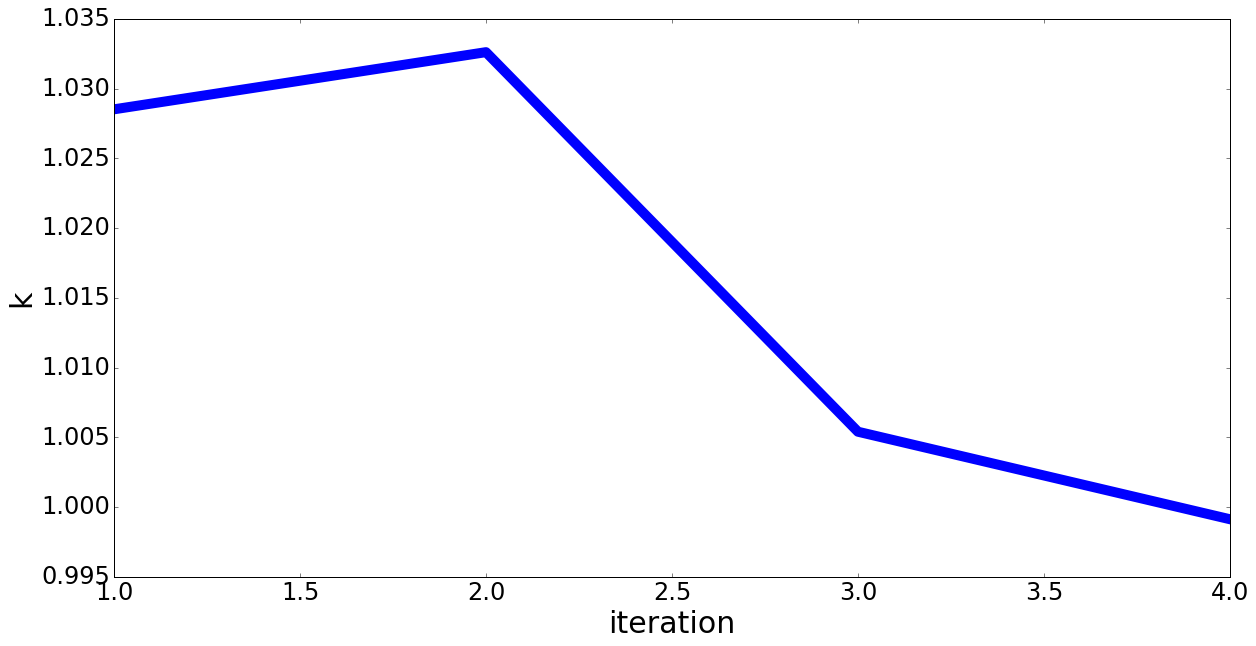

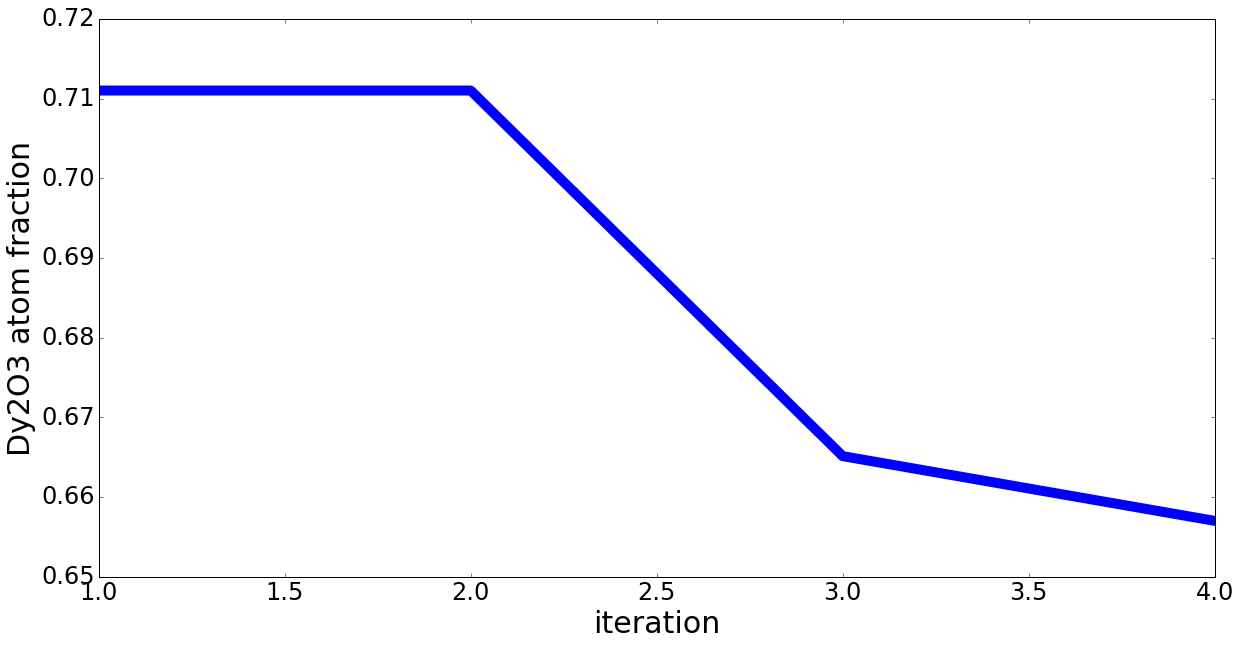

In [37]:
def main():
    q1part=PART_C   #does part a and b
    #rectQ(1,q1part)
    q2part=PART_C
    rectQ(2,q2part)
    #q3part=PART_A 
    #rectQ(3,q3part)
    #triangQ(3,q3part)
    

main()